In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.regression.rolling import RollingOLS
import plotly.graph_objects as go
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [18]:
def flexible_backtest(
    data,
    price_col_name,
    signal_col_name,
    strategy_type="state",
    row_shift=1,
    p_spread=0.0,
):
    """
    Performs a flexible backtest with three logic modes.

    Args:
        data (pd.DataFrame): DataFrame with price and signal.
        price_col_name (str): The name of the price column.
        signal_col_name (str): The name of the signal column.
        strategy_type (str): The type of backtest to run:
            - 'state': (Fast, Vectorized) Assumes signal is the
                       FINAL desired position (1, -1, 0).
            - 'event_hold': (Loop) Assumes signal is a "pulse" (1, -1, 0).
                            Holds position on 0. Max pos is 1 or -1.
            - 'event_pyramid': (Loop) Assumes signal is a "pulse" (1, -1, 0).
                               Adds to position on signal (1, 2, 3...).
        row_shift (int): The lag between signal generation and execution.
        p_spread (float): Cost (as a decimal) to apply per unit traded.

    Returns:
        pd.DataFrame: A new DataFrame with all backtest results.
    """

    # 1. --- Setup ---
    df = data.copy()
    df["log_returns"] = np.log(df[price_col_name]).diff()

    # ========================================================================
    # 2. --- LOGIC PATH A: 'state' (Vectorized) ---
    # ========================================================================
    if strategy_type == "state":
        df["position"] = df[signal_col_name].shift(row_shift)
        df["strategy_returns"] = df["position"] * df["log_returns"]
        df["position_change"] = df["position"].diff().abs()
        df["slippage_cost"] = df["position_change"] * p_spread
        df["strategy_returns_net"] = df["strategy_returns"] - df["slippage_cost"]

    # ========================================================================
    # 2. --- LOGIC PATH B: 'event_hold' (Loop-Based, Your New Logic) ---
    # ========================================================================
    elif strategy_type == "event_hold":
        df["position"] = 0.0
        df["position_change"] = 0.0
        df["slippage_cost"] = 0.0
        df["strategy_returns_net"] = 0.0

        for i in range(row_shift, len(df)):
            signal = df[signal_col_name].iloc[i - row_shift]
            yesterday_pos = df["position"].iloc[i - 1]

            # Determine Today's Position (Hold Logic)
            today_pos = yesterday_pos  # Default: Hold position

            if signal == 1:
                today_pos = 1  # Go long (or stay long)
            elif signal == -1:
                today_pos = -1  # Go short (or stay short)
            elif signal == 2:
                today_pos = 0
            # If signal is 0, today_pos remains yesterday_pos (hold)

            df.iloc[i, df.columns.get_loc("position")] = today_pos

            # Calculate P&L and Costs
            pos_change = abs(today_pos - yesterday_pos)
            cost = pos_change * p_spread
            gross_return = today_pos * df["log_returns"].iloc[i]
            net_return = gross_return - cost

            df.iloc[i, df.columns.get_loc("position_change")] = pos_change
            df.iloc[i, df.columns.get_loc("slippage_cost")] = cost
            df.iloc[i, df.columns.get_loc("strategy_returns_net")] = net_return

# ========================================================================
    # 2. --- LOGIC PATH C: 'event_pyramid' (Loop-Based) ---
    # --- THIS IS THE MODIFIED SECTION ---
    # ========================================================================
    elif strategy_type == "event_pyramid":
        df["position"] = 0.0
        df["position_change"] = 0.0
        df["slippage_cost"] = 0.0
        df["strategy_returns_net"] = 0.0

        for i in range(row_shift, len(df)):
            signal = df[signal_col_name].iloc[i - row_shift]
            yesterday_pos = df["position"].iloc[i - 1]

            # Determine Today's Position (Your New Pyramiding Logic)
            today_pos = yesterday_pos # Default: Hold

            if signal == 1:
                if yesterday_pos < 0:
                    today_pos = 1  # Flip from short to 1 long
                else:
                    today_pos = yesterday_pos + 1  # Add to long
            elif signal == -1:
                if yesterday_pos > 0:
                    today_pos = -1  # Flip from long to 1 short
                else:
                    today_pos = yesterday_pos - 1  # Add to short
            elif signal == 2:
                today_pos = 0 # Close all positions
            
            df.iloc[i, df.columns.get_loc("position")] = today_pos

            # Calculate P&L and Costs
            pos_change = abs(today_pos - yesterday_pos)
            cost = pos_change * p_spread
            gross_return = today_pos * df["log_returns"].iloc[i]
            net_return = gross_return - cost

            df.iloc[i, df.columns.get_loc("position_change")] = pos_change
            df.iloc[i, df.columns.get_loc("slippage_cost")] = cost
            df.iloc[i, df.columns.get_loc("strategy_returns_net")] = net_return
    # --- END OF MODIFIED SECTION ---
    
    else:
        raise ValueError(
            f"Unknown strategy_type: '{strategy_type}'. "
            "Must be 'state', 'event_hold', or 'event_pyramid'."
        )

    # 3. --- Post-Processing (Common to all) ---
    df["cumulative_strategy"] = df["strategy_returns_net"].cumsum().apply(np.exp)
    df["cumulative_buy_and_hold"] = df["log_returns"].cumsum().apply(np.exp)

    # Clean up
    results = df.iloc[row_shift:].copy()
    results.dropna(subset=["log_returns", "cumulative_strategy"], inplace=True)

    return results

In [3]:
# --- 1. Get Data ---
period = '50y'
EURUSD_TICKER = 'EURUSD=X'
EURUSD_DATA = yf.Ticker(EURUSD_TICKER).history(period=period)['Close']
GBPUSD_TICKER = 'GBPUSD=X'
GBPUSD_DATA = yf.Ticker(GBPUSD_TICKER).history(period=period)['Close']
USDJPY_TICKER = 'USDJPY=X'
USDJPY_DATA = yf.Ticker(USDJPY_TICKER).history(period=period)['Close']
USDCHF_TICKER = 'USDCHF=X'
USDCHF_DATA = yf.Ticker(USDCHF_TICKER).history(period=period)['Close']

In [4]:


# Download the closing prices
# stock_data = yf.Ticker(stock_ticker).history(start=start_date, end=end_date)['Close']
# market_data = yf.Ticker(market_ticker).history(start=start_date, end=end_date)['Close']
pair_1_data = EURUSD_DATA.copy()
pair_2_data = GBPUSD_DATA.copy()
pair_3_data = USDJPY_DATA.copy()
pair_4_data = USDCHF_DATA.copy()
pair_1_data.index = pair_1_data.index.date
pair_2_data.index = pair_2_data.index.date
pair_3_data.index = pair_3_data.index.date
pair_4_data.index = pair_4_data.index.date

# Combine into one DataFrame and drop any missing (e.g., holiday)
# df = pd.DataFrame({'stock': stock_data, 'market': market_data}).dropna()
df = pd.DataFrame({'pair_1': pair_1_data, 'pair_2': pair_2_data}).dropna()


--- Cointegration Test on Rolling Spread (Window=60) ---
ADF Test p-value: 0.0000
Result: The pair IS cointegrated. The model is valid.



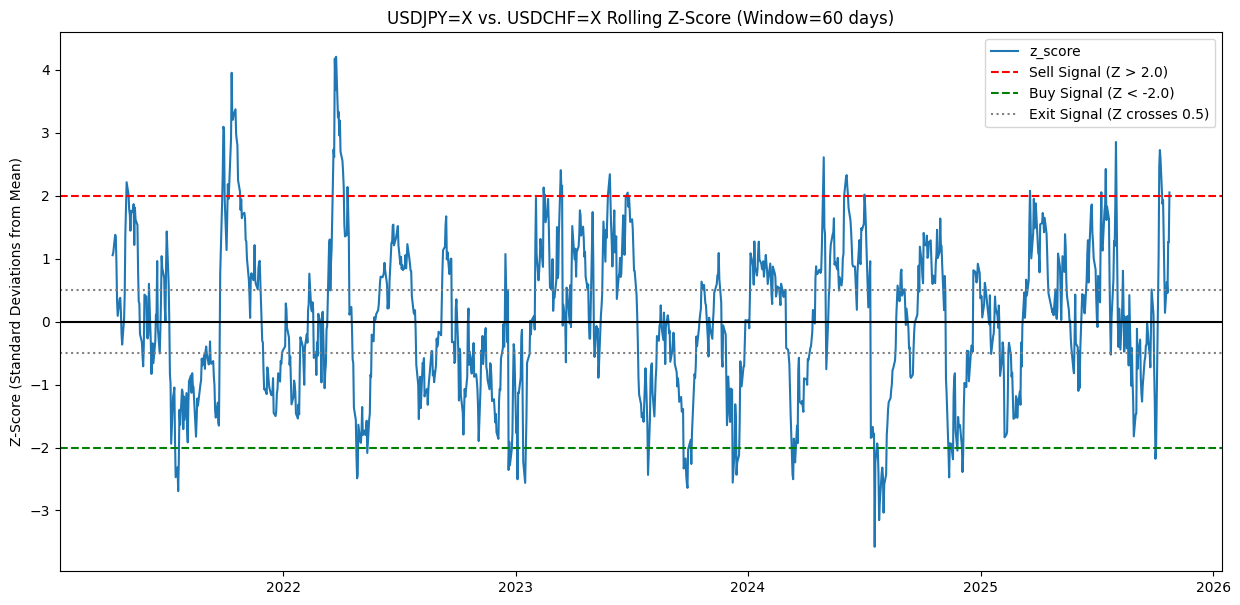

In [169]:
df = pd.DataFrame({'stock': stock_data, 'market': market_data}).dropna()

# --- 2. Define Your "Tuning" Parameters ---
# KNOB 1: The Lookback Window (in days)
# Try 60, 120, 252 (trading days in a year)
window = 60

# KNOB 2: The Z-Score Thresholds for Entry/Exit
# Try 1.5, 2.0, 2.5
entry_threshold = 2.0
exit_threshold = 0.5 

# --- 3. Calculate the Rolling Hedge Ratio (Beta) ---
# We use log-prices to model the *percentage* relationship, which is more stable
y = np.log(df['stock'])
X = sm.add_constant(np.log(df['market'])) # Add a constant for the intercept (alpha)

# This runs an OLS regression for *every* 'window'-day period
rolling_model = RollingOLS(y, X, window=window)
rolling_fit = rolling_model.fit()

# --- THIS IS THE FIX ---
# Get the rolling parameters from the fit
rolling_params = rolling_fit.params
alpha = rolling_params['const']
beta = rolling_params['market']

# Manually calculate the spread (the residual)
# spread = y - (alpha + beta * X['market'])
spread = np.log(df['stock']) - (alpha + beta * np.log(df['market']))

# --- 4. Calculate the Rolling Z-Score (The Signal) ---
# We now calculate the Z-Score *of the spread*
rolling_mean = spread.rolling(window=window).mean()
rolling_std = spread.rolling(window=window).std()

df['z_score'] = (spread - rolling_mean) / rolling_std

# Drop the initial NaN values created by the rolling windows
df.dropna(inplace=True)

# --- 5. (Optional but Recommended) Check Cointegration ---
# Now that we have the final spread, let's test it
adf_result = adfuller(spread.dropna())
p_value = adf_result[1]

print(f"--- Cointegration Test on Rolling Spread (Window={window}) ---")
print(f"ADF Test p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Result: The pair IS cointegrated. The model is valid.\n")
else:
    print("Result: WARNING! The pair is NOT cointegrated.\n")

# --- 6. Visualize the Tuned Model ---
plt.figure(figsize=(15, 7))
df['z_score'].plot()

plt.axhline(entry_threshold, color='red', linestyle='--', label=f'Sell Signal (Z > {entry_threshold})')
plt.axhline(-entry_threshold, color='green', linestyle='--', label=f'Buy Signal (Z < -{entry_threshold})')
plt.axhline(exit_threshold, color='gray', linestyle=':', label=f'Exit Signal (Z crosses {exit_threshold})')
plt.axhline(-exit_threshold, color='gray', linestyle=':')
plt.axhline(0.0, color='black', linestyle='-')

plt.title(f'{stock_ticker} vs. {market_ticker} Rolling Z-Score (Window={window} days)')
plt.ylabel('Z-Score (Standard Deviations from Mean)')
plt.legend()
plt.show()

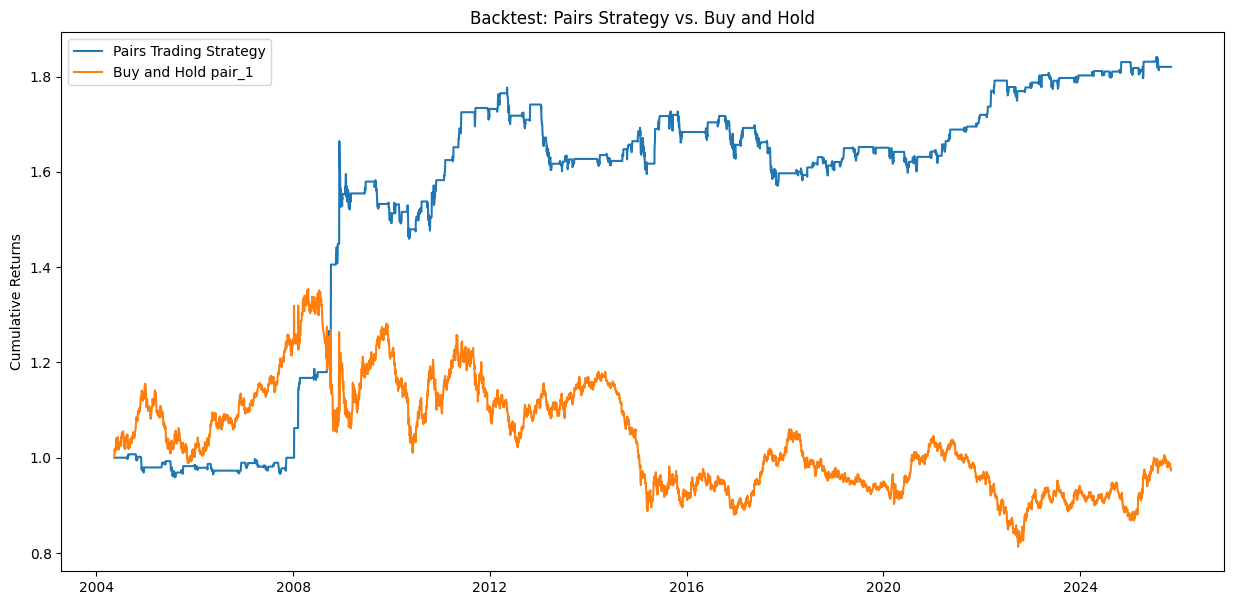

In [178]:
df = pd.DataFrame({'pair_1': pair_1_data, 'pair_2': pair_2_data}).dropna()

# Use log prices for a more stable relationship
df['log_price_1'] = np.log(df['pair_1'])
df['log_price_2'] = np.log(df['pair_2'])

# --- 2. Define Your "Tuning" Parameters ---
window = 60 # Lookback window (in days)
entry_threshold = 2.0
exit_threshold = 0.5 
stop_loss_threshold = 4

# --- 3. Calculate the Rolling Hedge Ratio (Beta) & Spread ---
y = df['log_price_1']
X = sm.add_constant(df['log_price_2']) # Add a constant for the intercept (alpha)

rolling_model = RollingOLS(y, X, window=window)
rolling_fit = rolling_model.fit()
rolling_params = rolling_fit.params

# Get the rolling alpha and beta (hedge ratio)
alpha = rolling_params['const']
beta = rolling_params['log_price_2'] # This is our hedge ratio
df['beta'] = beta # Save it for our returns calculation

# Calculate the spread (the divergence)
spread = df['log_price_1'] - (alpha + beta * df['log_price_2'])

# --- 4. Calculate the Rolling Z-Score (The Signal) ---
rolling_mean = spread.rolling(window=window).mean()
rolling_std = spread.rolling(window=window).std()

df['z_score'] = (spread - rolling_mean) / rolling_std

# Drop all NaNs created by the rolling windows
df.dropna(inplace=True)

# --- 5. Generate Positions with a Loop (State-Based) ---
df['position'] = 0  # 0=Flat, 1=Long Spread, -1=Short Spread
current_position = 0

for i in range(len(df)):
    z_score = df['z_score'].iloc[i]
    
    # --- Logic for when we are FLAT (0) ---
    if current_position == 0:
        if z_score < -entry_threshold:
            current_position = 1  # Buy Spread (Long Pair 1, Short Pair 2)
        elif z_score > entry_threshold:
            current_position = -1 # Sell Spread (Short Pair 1, Long Pair 2)
            
    # --- Logic for when we are LONG SPREAD (1) ---
    elif current_position == 1:
        if z_score >= -exit_threshold: # Profit-take
            current_position = 0
        elif z_score < -stop_loss_threshold: # Stop-loss
            current_position = 0
            
    # --- Logic for when we are SHORT SPREAD (-1) ---
    elif current_position == -1:
        if z_score <= exit_threshold: # Profit-take
            current_position = 0
        elif z_score > stop_loss_threshold: # Stop-loss
            current_position = 0
            
    df.iloc[i, df.columns.get_loc('position')] = current_position

# --- 6. Calculate Strategy Returns (Corrected Hedged Method) ---
df['position'] = df['position'].shift(1) # Shift position by 1 day

# Calculate the daily returns for each pair
df['pair_1_returns'] = df['log_price_1'].diff()
df['pair_2_returns'] = df['log_price_2'].diff()

# --- THIS IS THE CRITICAL CORRECTION ---
# Your strategy return is the return of your long leg minus the return of your short leg.
# The hedge ratio (beta) must be used.
# position = 1 means: +1 * (return_1) - beta * (return_2)
# position = -1 means: -1 * (return_1) + beta * (return_2)
# This simplifies to:
df['strategy_returns'] = df['position'] * (df['pair_1_returns'] - df['beta'] * df['pair_2_returns'])

# --- 7. Calculate Cumulative Returns (Equity Curve) ---
# We also compare to just buying and holding Pair 1
df['buy_and_hold_returns'] = df['pair_1_returns'].fillna(0)

cumulative_strategy_returns = df['strategy_returns'].cumsum().apply(np.exp)
cumulative_buy_and_hold_returns = df['buy_and_hold_returns'].cumsum().apply(np.exp)

# --- 8. Plot the Final Performance Test ---
plt.figure(figsize=(15, 7))
cumulative_strategy_returns.plot(label='Pairs Trading Strategy')
cumulative_buy_and_hold_returns.plot(label=f'Buy and Hold pair_1')
plt.title('Backtest: Pairs Strategy vs. Buy and Hold')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

Starting manual rolling window calculation... This may take a moment.
Calculation complete.


C:\Users\owyongg\AppData\Local\Temp\ipykernel_1372\1721136426.py:109: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['beta'].fillna(method='ffill', inplace=True)
C:\Users\owyongg\AppData\Local\Temp\ipykernel_1372\1721136426.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['beta'].fillna(method='ffill', inplace=True)


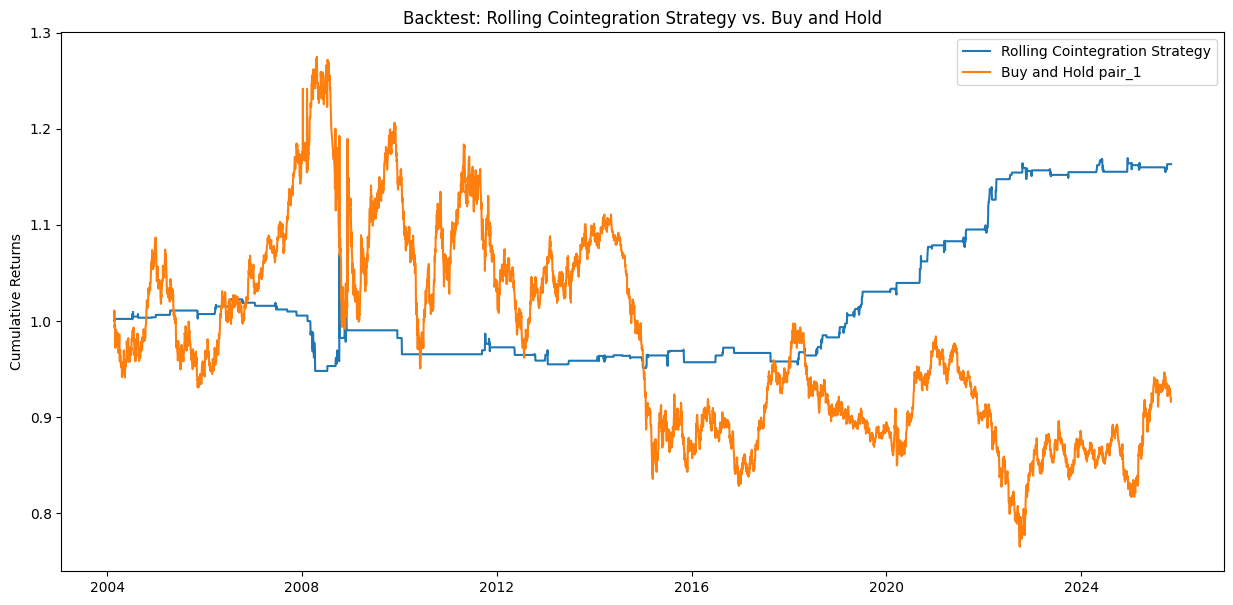

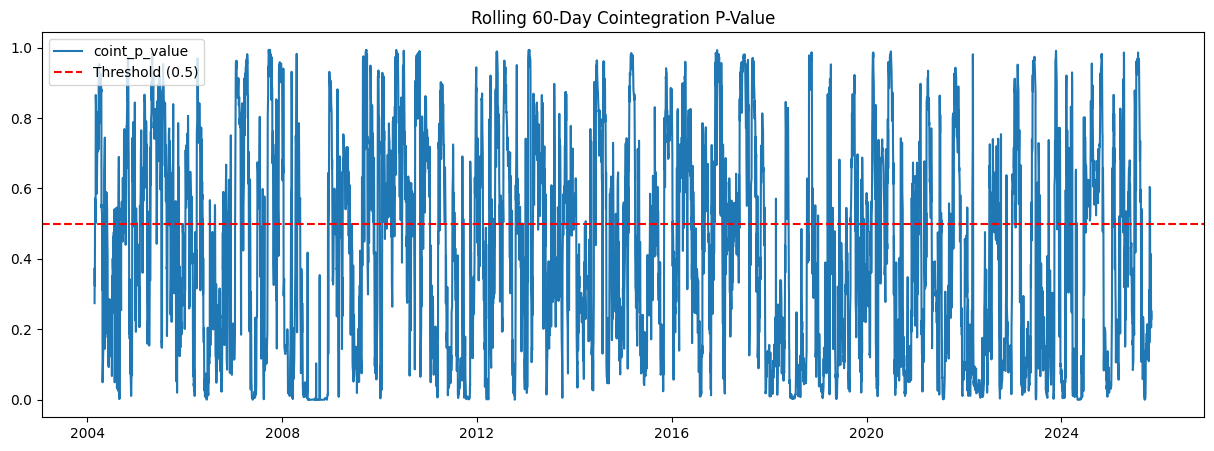

In [179]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt

# --- 1. Load and Prepare Data (Same as before) ---
# np.random.seed(42)
# days = 1000
# pair_1_data = 100 + np.cumsum(np.random.randn(days))
# pair_2_data = pair_1_data + np.random.randn(days)
df = pd.DataFrame({'pair_1': pair_1_data, 'pair_2': pair_2_data}).dropna()

df['log_price_1'] = np.log(df['pair_1'])
df['log_price_2'] = np.log(df['pair_2'])

# --- 2. Define Your "Tuning" Parameters ---
window = 60 # Lookback window (in days)
entry_threshold = 2.0
exit_threshold = 0.5 
stop_loss_threshold = 4.0
cointegration_threshold = 0.5 # p-value to beat

# --- 3. Prepare DataFrame for Manual Rolling Loop ---
# We will fill these in the loop
df['coint_p_value'] = 1.0 # Default to 1.0 (not cointegrated)
df['beta'] = np.nan
df['z_score'] = 0.0
df['position'] = 0  # 0=Flat, 1=Long Spread, -1=Short Spread

# Get the raw series for faster slicing in the loop
y_series = df['log_price_1']
x_series = df['log_price_2']

print("Starting manual rolling window calculation... This may take a moment.")

# --- 4. Main Loop for Rolling Cointegration & OLS ---
# We must start at 'window' to have enough data
for i in range(window, len(df)):
    # --- Get the window slice ---
    y_window = y_series.iloc[i - window : i]
    x_window = x_series.iloc[i - window : i]

    # --- Step 4a: Run Cointegration Test on the window ---
    coint_score, p_value, _ = coint(y_window, x_window)
    df.iloc[i, df.columns.get_loc('coint_p_value')] = p_value

    # Get the position from the PREVIOUS day
    current_position = df.iloc[i - 1, df.columns.get_loc('position')]

    # --- Step 4b: Check if this window is cointegrated ---
    if p_value <= cointegration_threshold:
        # IT IS cointegrated. Proceed with OLS and Z-Score logic.
        
        # Run OLS on this window to get hedge ratio
        X_const_window = sm.add_constant(x_window)
        ols_model = sm.OLS(y_window, X_const_window).fit()
        
        alpha = ols_model.params.iloc[0]
        beta = ols_model.params.iloc[1]
        df.iloc[i, df.columns.get_loc('beta')] = beta

        # Calculate spread & z-score *for this window*
        spread_window = y_window - (alpha + beta * x_window)
        spread_mean = spread_window.mean()
        spread_std = spread_window.std()
        
        # Get the z-score for the *most recent point*
        current_spread = spread_window.iloc[-1]
        z_score = (current_spread - spread_mean) / spread_std
        df.iloc[i, df.columns.get_loc('z_score')] = z_score

        # --- Step 4c: Apply Trading Logic (State-Based) ---
        new_position = current_position # Default to holding position
        
        if current_position == 0:
            if z_score < -entry_threshold:
                new_position = 1  # Buy Spread
            elif z_score > entry_threshold:
                new_position = -1 # Sell Spread
                
        elif current_position == 1:
            if z_score >= -exit_threshold: # Profit-take
                new_position = 0
            elif z_score < -stop_loss_threshold: # Stop-loss
                new_position = 0
                
        elif current_position == -1:
            if z_score <= exit_threshold: # Profit-take
                new_position = 0
            elif z_score > stop_loss_threshold: # Stop-loss
                new_position = 0
        
        df.iloc[i, df.columns.get_loc('position')] = new_position
        
    else:
        # IT IS NOT cointegrated.
        # Force-close any open position, as our premise is invalid.
        df.iloc[i, df.columns.get_loc('position')] = 0

print("Calculation complete.")

# --- 5. Calculate Strategy Returns (Same as before) ---
df['position'] = df['position'].shift(1) # Shift position by 1 day

# Fill NaNs in beta *after* the shift, using ffill
# This ensures we use the "last valid beta" during a non-coint period if we
# are still holding a position from the previous day.
df['beta'].fillna(method='ffill', inplace=True) 

# Calculate daily returns
df['pair_1_returns'] = df['log_price_1'].diff()
df['pair_2_returns'] = df['log_price_2'].diff()

df.dropna(subset=['pair_1_returns', 'pair_2_returns', 'beta'], inplace=True)

# Calculate strategy returns
df['strategy_returns'] = df['position'] * (df['pair_1_returns'] - df['beta'] * df['pair_2_returns'])
df['buy_and_hold_returns'] = df['pair_1_returns'].fillna(0)

# --- 6. Calculate Cumulative Returns (Equity Curve) ---
cumulative_strategy_returns = df['strategy_returns'].cumsum().apply(np.exp)
cumulative_buy_and_hold_returns = df['buy_and_hold_returns'].cumsum().apply(np.exp)

# --- 7. Plot the Final Performance Test ---
plt.figure(figsize=(15, 7))
cumulative_strategy_returns.plot(label='Rolling Cointegration Strategy')
cumulative_buy_and_hold_returns.plot(label=f'Buy and Hold pair_1')
plt.title('Backtest: Rolling Cointegration Strategy vs. Buy and Hold')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# --- 8. (Optional) Plot the rolling p-value ---
plt.figure(figsize=(15, 5))
df['coint_p_value'].plot()
plt.axhline(cointegration_threshold, color='red', linestyle='--', label=f'Threshold ({cointegration_threshold})')
plt.title('Rolling 60-Day Cointegration P-Value')
plt.legend()
plt.show()

In [172]:
pair_1_data

2003-12-01    1.196501
2003-12-02    1.208897
2003-12-03    1.212298
2003-12-04    1.208094
2003-12-05    1.218695
                ...   
2025-10-31    1.157247
2025-11-03    1.152804
2025-11-04    1.151914
2025-11-05    1.148554
2025-11-06    1.152472
Name: Close, Length: 5692, dtype: float64

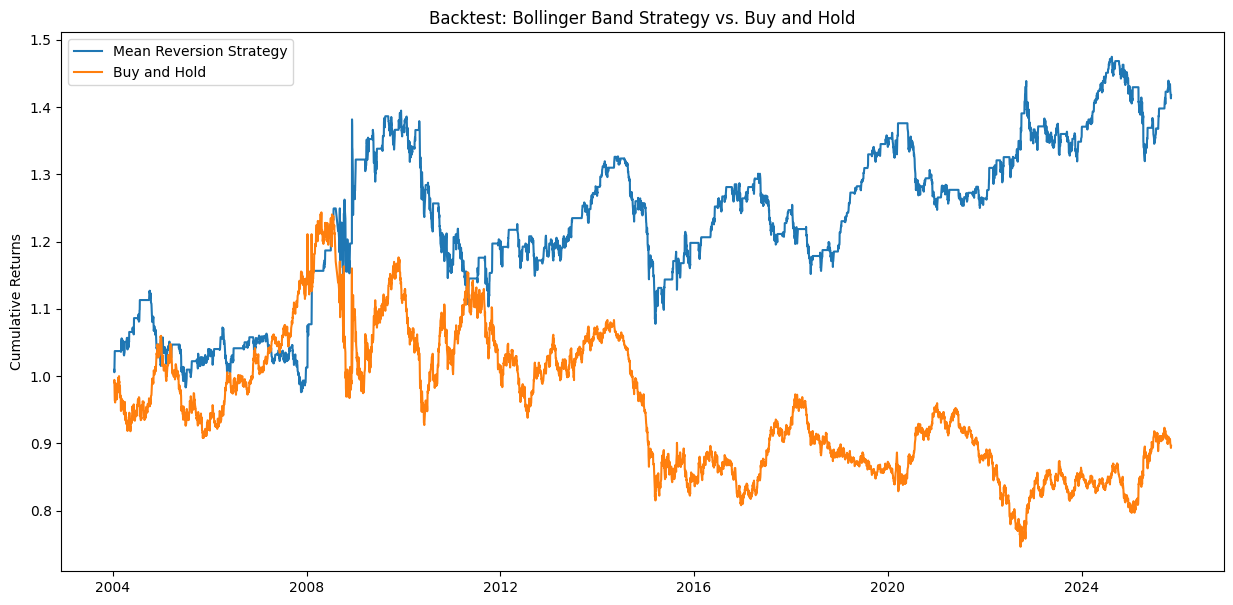

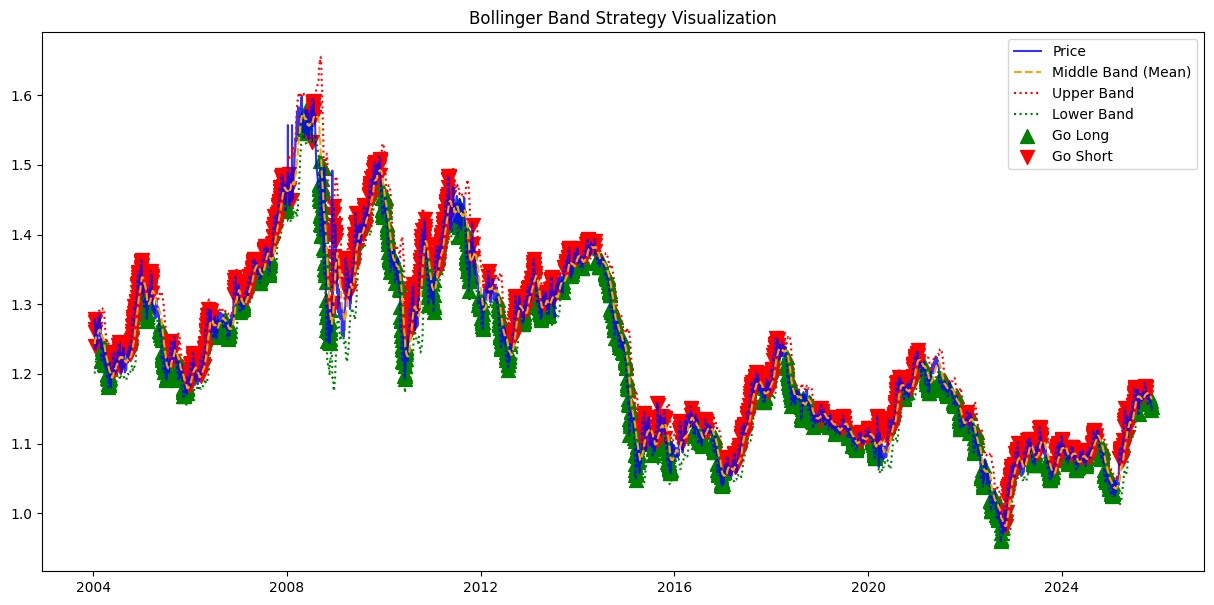

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Create Dummy Data ---
# We'll create a synthetic sine wave + noise, which is naturally mean-reverting
# np.random.seed(42)
# days = 500
# price = 100 + np.sin(np.linspace(0, 20, days)) * 5 + np.random.randn(days) * 0.5
df = pd.DataFrame({'price': pair_1_data})

# --- 2. Define Parameters & Calculate Bands ---
window = 30  # Lookback window for rolling mean and std
std_devs = 2 # Number of standard deviations for the bands

# Calculate the Middle Band (Simple Moving Average)
df['rolling_mean'] = df['price'].rolling(window=window).mean()

# Calculate the Standard Deviation
df['rolling_std'] = df['price'].rolling(window=window).std()

# Calculate Upper and Lower Bands
df['upper_band'] = df['rolling_mean'] + (df['rolling_std'] * std_devs)
df['lower_band'] = df['rolling_mean'] - (df['rolling_std'] * std_devs)

df.dropna(inplace=True) # Remove NaNs from rolling windows

# --- 3. Generate Positions (State-Based Loop) ---
df['position'] = 0  # 0=Flat, 1=Long, -1=Short
current_position = 0

for i in range(len(df)):
    price = df['price'].iloc[i]
    lower_band = df['lower_band'].iloc[i]
    upper_band = df['upper_band'].iloc[i]
    middle_band = df['rolling_mean'].iloc[i]
    
    # --- Logic for when we are FLAT (0) ---
    if current_position == 0:
        if price < lower_band:
            current_position = 1  # Buy (oversold)
        elif price > upper_band:
            current_position = -1 # Sell (overbought)
            
    # --- Logic for when we are LONG (1) ---
    elif current_position == 1:
        if price >= middle_band:
            current_position = 0  # Exit (reverted to mean)
            
    # --- Logic for when we are SHORT (-1) ---
    elif current_position == -1:
        if price <= middle_band:
            current_position = 0  # Exit (reverted to mean)
            
    df.iloc[i, df.columns.get_loc('position')] = current_position

# --- 4. Calculate Strategy Returns ---
df['position'] = df['position'].shift(1).fillna(0) # Shift position for next-day execution

# Use log returns
df['log_returns'] = np.log(df['price']).diff()
df.dropna(inplace=True)

df['strategy_returns'] = df['position'] * df['log_returns']
df['buy_and_hold_returns'] = df['log_returns']

# --- 5. Calculate and Plot Cumulative Returns ---
cumulative_strategy_returns = df['strategy_returns'].cumsum().apply(np.exp)
cumulative_buy_and_hold_returns = df['buy_and_hold_returns'].cumsum().apply(np.exp)

plt.figure(figsize=(15, 7))
cumulative_strategy_returns.plot(label='Mean Reversion Strategy')
cumulative_buy_and_hold_returns.plot(label='Buy and Hold')
plt.title('Backtest: Bollinger Band Strategy vs. Buy and Hold')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


# --- 6. (Optional) Plot the signals ---
plt.figure(figsize=(15, 7))
df['price'].plot(label='Price', color='blue', alpha=0.8)
df['rolling_mean'].plot(label='Middle Band (Mean)', color='orange', linestyle='--')
df['upper_band'].plot(label='Upper Band', color='red', linestyle=':')
df['lower_band'].plot(label='Lower Band', color='green', linestyle=':')

# Plot Buy signals
buy_signals = df[df['position'] == 1]
plt.scatter(buy_signals.index, buy_signals['price'], 
            marker='^', color='green', s=100, label='Go Long')

# Plot Sell signals
sell_signals = df[df['position'] == -1]
plt.scatter(sell_signals.index, sell_signals['price'], 
            marker='v', color='red', s=100, label='Go Short')

plt.title('Bollinger Band Strategy Visualization')
plt.legend()
plt.show()

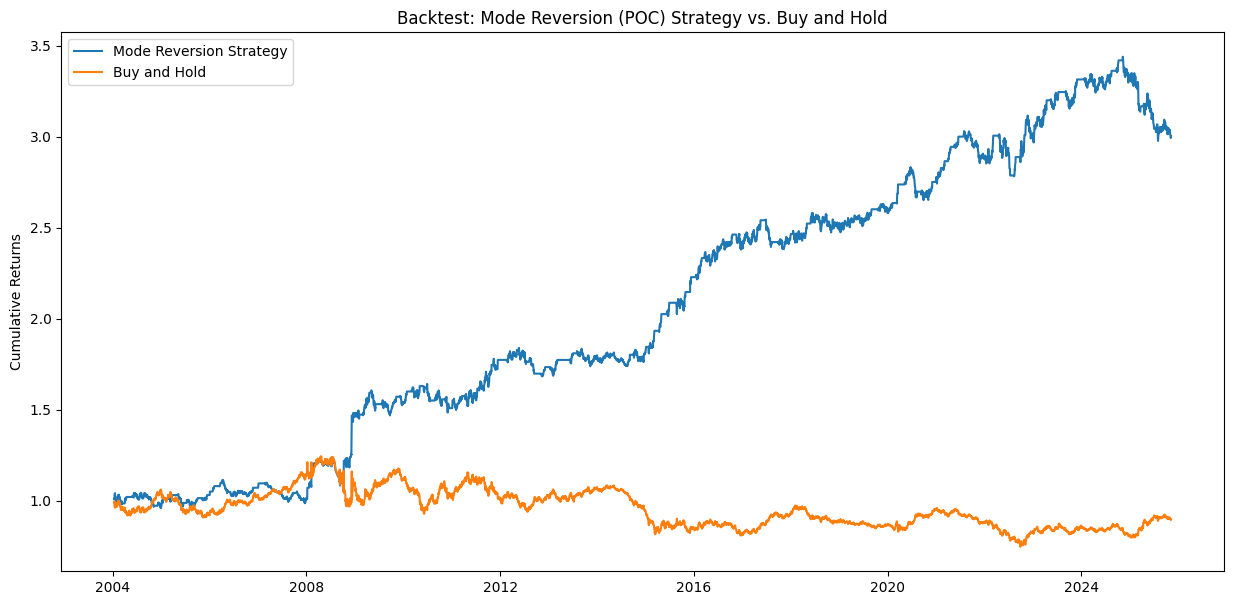

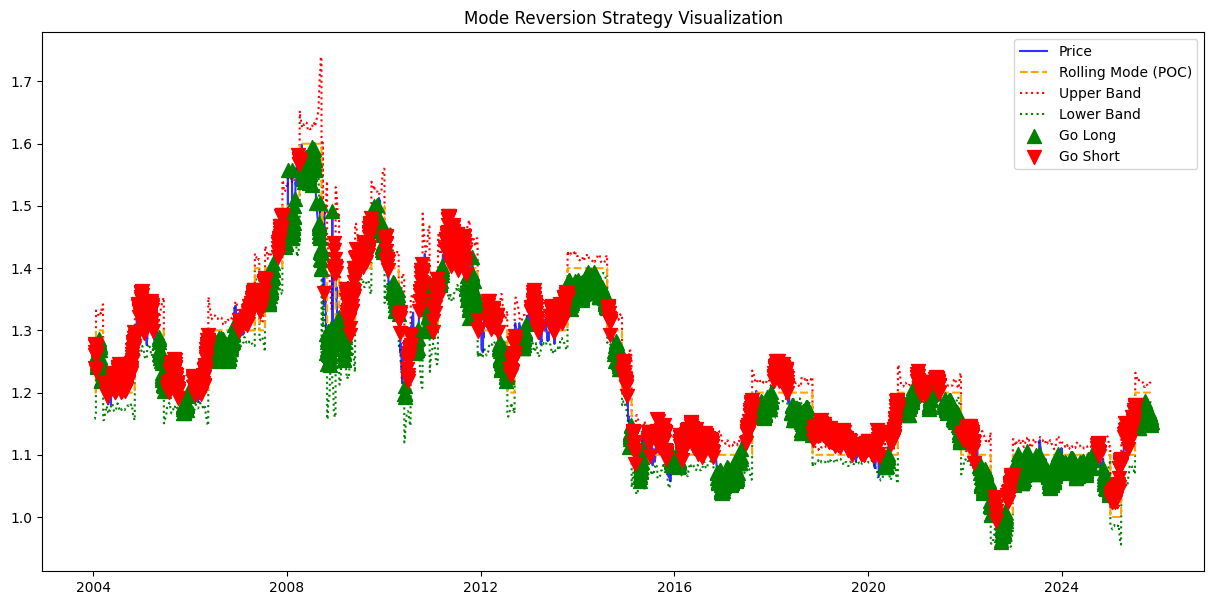

In [220]:
df = pd.DataFrame({'price': pair_1_data})

# --- 2. Define Parameters ---
window = 30         # Lookback window
std_devs = 2.0      # Number of standard deviations for entry bands
price_precision = 1 # Round to 1 decimal place (e.g., 100.1)

# --- 3. Calculate the Rolling Mode & Bands ---

# Step 3a: Create the "binned" price by rounding
df['rounded_price'] = df['price'].round(price_precision)

# Step 3b: Calculate the rolling mode.
# This is slow, as mode is not a simple vectorized operation.
# We use .apply() to get the mode of the 'rounded_price' for each window.
# .mode() returns a Series (in case of ties), so we take the first item.
df['rolling_mode'] = df['rounded_price'].rolling(window=window).apply(lambda x: x.mode().iloc[0], raw=False)

# Step 3c: Calculate standard deviation of the *actual* price (not rounded)
df['rolling_std'] = df['price'].rolling(window=window).std()

# Step 3d: Create the bands based on the mode
df['upper_band'] = df['rolling_mode'] + (df['rolling_std'] * std_devs)
df['lower_band'] = df['rolling_mode'] - (df['rolling_std'] * std_devs)

df.dropna(inplace=True) # Remove NaNs

# --- 4. Generate Positions (State-Based Loop) ---
df['position'] = 0  # 0=Flat, 1=Long, -1=Short
current_position = 0

for i in range(len(df)):
    price = df['price'].iloc[i]
    lower_band = df['lower_band'].iloc[i]
    upper_band = df['upper_band'].iloc[i]
    # Our exit target is the 'rolling_mode' (the POC)
    mode_target = df['rolling_mode'].iloc[i] 
    
    # --- Logic for when we are FLAT (0) ---
    if current_position == 0:
        if price < lower_band:
            current_position = 1  # Buy (price is in "low value" area)
        elif price > upper_band:
            current_position = -1 # Sell (price is in "high value" area)
            
    # --- Logic for when we are LONG (1) ---
    elif current_position == 1:
        if price >= mode_target:
            current_position = 0  # Exit (reverted to mode/POC)
            
    # --- Logic for when we are SHORT (-1) ---
    elif current_position == -1:
        if price <= mode_target:
            current_position = 0  # Exit (reverted to mode/POC)
            
    df.iloc[i, df.columns.get_loc('position')] = current_position

# --- 5. Calculate Strategy Returns ---
df['position'] = df['position'].shift(1).fillna(0) # Shift position

df['log_returns'] = np.log(df['price']).diff()
df.dropna(inplace=True)

df['strategy_returns'] = df['position'] * df['log_returns']
df['buy_and_hold_returns'] = df['log_returns']

# --- 6. Calculate and Plot Cumulative Returns ---
cumulative_strategy_returns = df['strategy_returns'].cumsum().apply(np.exp)
cumulative_buy_and_hold_returns = df['buy_and_hold_returns'].cumsum().apply(np.exp)

plt.figure(figsize=(15, 7))
cumulative_strategy_returns.plot(label='Mode Reversion Strategy')
cumulative_buy_and_hold_returns.plot(label='Buy and Hold')
plt.title('Backtest: Mode Reversion (POC) Strategy vs. Buy and Hold')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


# --- 7. (Optional) Plot the signals ---
plt.figure(figsize=(15, 7))
df['price'].plot(label='Price', color='blue', alpha=0.8, zorder=2)
df['rolling_mode'].plot(label='Rolling Mode (POC)', color='orange', linestyle='--', zorder=3)
df['upper_band'].plot(label='Upper Band', color='red', linestyle=':', zorder=1)
df['lower_band'].plot(label='Lower Band', color='green', linestyle=':', zorder=1)

# Plot Buy/Sell signals
buy_signals = df[df['position'] == 1]
plt.scatter(buy_signals.index, buy_signals['price'], 
            marker='^', color='green', s=100, label='Go Long', zorder=5)

sell_signals = df[df['position'] == -1]
plt.scatter(sell_signals.index, sell_signals['price'], 
            marker='v', color='red', s=100, label='Go Short', zorder=5)

plt.title('Mode Reversion Strategy Visualization')
plt.legend()
plt.show()

In [25]:
df = pd.DataFrame({'price': pair_1_data})

window = 30
std_devs = 2.0
price_precision = 1

print("Calculating rolling mode...")
df['rounded_price'] = df['price'].round(price_precision)
df['rolling_mode'] = df['rounded_price'].rolling(window=window).apply(lambda x: x.mode().iloc[0], raw=False)
df['rolling_std'] = df['price'].rolling(window=window).std()
df['upper_band'] = df['rolling_mode'] + (df['rolling_std'] * std_devs)
df['lower_band'] = df['rolling_mode'] - (df['rolling_std'] * std_devs)

# --- B. Create "Instruction" Signals (Vectorized) ---
df['signal'] = 0  # Create the column
current_position = 0

for i in range(len(df)):
    price = df['price'].iloc[i]
    lower_band = df['lower_band'].iloc[i]
    upper_band = df['upper_band'].iloc[i]
    mode_target = df['rolling_mode'].iloc[i] 
    
    if current_position == 0:
        if price < lower_band: 
            current_position = 1
        elif price > upper_band: 
            current_position = -1
    elif current_position == 1:
        if price >= mode_target: 
            current_position = 0
    elif current_position == -1:
        if price <= mode_target: 
            current_position = 0
            
    df.iloc[i, df.columns.get_loc('signal')] = current_position
df.dropna(inplace=True)

Calculating rolling mode...


In [26]:
df.index = pd.to_datetime(df.index)
filtered_df = df.copy()
# filtered_df = filtered_df.loc['2021-01-01':]
print("Running backtest...")
results = flexible_backtest(
    data=filtered_df,
    price_col_name="price",
    signal_col_name="signal",
    row_shift=1,  # Your 2-day manual lag
    p_spread=0,
    strategy_type='event_hold'
)  # 0.01% cost

# --- Plot 1: P&L Curve ---
print("Displaying Plot 1: Cumulative P&L")
fig = go.Figure()
fig.add_trace(go.Scatter(x=results.index, y=results['cumulative_strategy'],
                         mode='lines', name='Mode Reversion Strategy (Net)'))
fig.add_trace(go.Scatter(x=results.index, y=results['cumulative_buy_and_hold'],
                         mode='lines', name='Buy and Hold', line=dict(color='grey', dash='dash')))
fig.update_layout(title='Mode Reversion Backtest vs. Buy and Hold',
                  yaxis_title='Cumulative Returns',
                  hovermode='x unified')
fig.show()

# --- Plot 2: Position Size ---
print("Displaying Plot 2: Position Size")
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=results.index, y=results['position'],
                          mode='lines', name='Position Size',
                          line=dict(shape='hv'))) # 'hv' makes it a step-plot
fig2.update_layout(title='Position Over Time',
                   yaxis_title='Number of Units',
                   hovermode='x unified')
fig2.show()

# --- Plot 3: Daily PNL (Bar Chart) ---
print("Displaying Plot 3: Daily PNL with Average")
results['pnl_color'] = ['green' if x > 0 else 'red' for x in results['strategy_returns_net']]
fig3 = go.Figure()
fig3.add_trace(go.Bar(
    x=results.index,
    y=results['strategy_returns_net'], # <-- Corrected typo from previous attempt
    name='Daily PNL',
    marker_color=results['pnl_color']
))

# --- MODIFICATION: Add average line ---
avg_pnl = results['strategy_returns_net'].mean()
fig3.add_hline(
    y=avg_pnl, 
    line_dash="dash", 
    line_color="black",  # <-- FIX: Changed to a visible color
    annotation_text=f"Average PNL: {avg_pnl:.5f}", # Display value
    annotation_position="bottom right",
    annotation_font=dict(color="black") # <-- FIX: Changed to a visible color
)
# --- End of modification ---

fig3.update_layout(
    title='Daily Strategy PNL (Net) with Average',
    yaxis_title='Net Log Return',
    xaxis_title='Date'
)
fig3.show()

# --- Plot 4: Daily PNL Distribution ---
print("Displaying Plot 4: PNL Distribution")
fig4 = px.histogram(
    results, 
    x='strategy_returns_net',
    nbins=100,
    title='Distribution of Daily PNL'
)
fig4.update_layout(
    xaxis_title='Net Log Return (Daily PNL)',
    yaxis_title='Frequency (Count of Days)'
)
fig4.show()

Running backtest...
Displaying Plot 1: Cumulative P&L


Displaying Plot 2: Position Size


Displaying Plot 3: Daily PNL with Average


Displaying Plot 4: PNL Distribution


NameError: name 'px' is not defined

In [76]:
# --- 2. Split into Training and Testing Sets ---
# We use the first 70% of the data to *find* the relationship
# We use the last 30% to *trade* on it
split_index = int(len(df) * 0.7)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

print(f"Training data from {train_df.index.min()} to {train_df.index.max()}")
print(f"Testing data from {test_df.index.min()} to {test_df.index.max()}")

Training data from 2020-10-26 to 2024-04-22
Testing data from 2024-04-23 to 2025-10-24


In [77]:
# --- 3. Find the Hedge Ratio (Beta) on Training Data ---
# We use OLS (Ordinary Least Squares) regression
y = train_df['stock']
X = sm.add_constant(train_df['market']) # Add a constant for the intercept (alpha)

model = sm.OLS(y, X).fit()
beta = model.params['market']
alpha = model.params['const']

print(f"\n--- Step 1: Find Relationship ---")
print(f"Hedge Ratio (Beta): {beta:.4f}")
print(f"Alpha: {alpha:.4f}")


--- Step 1: Find Relationship ---
Hedge Ratio (Beta): 1.0971
Alpha: 0.0694


In [80]:
# --- 4. Test for Cointegration on Training Data ---
# We check if the "spread" (the divergence) is stationary
spread_train = train_df['stock'] - beta * train_df['market']
adf_result = adfuller(spread_train)
p_value = adf_result[1]
p_threshold = 0.1
print(f"\n--- Step 2: Test for Cointegration ---")
print(f"ADF Test p-value: {p_value:.4f}")

if p_value < p_threshold:
    print(f"Result: The pair IS cointegrated (p-value < {p_threshold}).")
    print("This strategy is valid. We can proceed.\n")
else:
    print(f"Result: The pair is NOT cointegrated (p-value >= {p_threshold}).")
    print("STOP HERE. This strategy will not work for this pair.\n")
    # In a real script, you would exit here
    # For this example, we'll proceed so you can see the (bad) chart


--- Step 2: Test for Cointegration ---
ADF Test p-value: 0.0580
Result: The pair IS cointegrated (p-value < 0.1).
This strategy is valid. We can proceed.



In [72]:
# --- 5. Calculate Z-Score (The Signal) on Test Data ---
# We must use the mean and std from the TRAINING data.
# This prevents any look-ahead bias.
spread_mean = spread_train.mean()
spread_std = spread_train.std()

print(f"--- Step 3: Calculate Z-Score ---")
print(f"Long-Term Spread Mean (from training): {spread_mean:.4f}")
print(f"Long-Term Spread Std Dev (from training): {spread_std:.4f}")

# Now, calculate the spread and Z-Score for the *test* data
spread_test = test_df['stock'] - beta * test_df['market']
test_df['z_score'] = (spread_test - spread_mean) / spread_std

--- Step 3: Calculate Z-Score ---
Long-Term Spread Mean (from training): 12.7112
Long-Term Spread Std Dev (from training): 1.9215


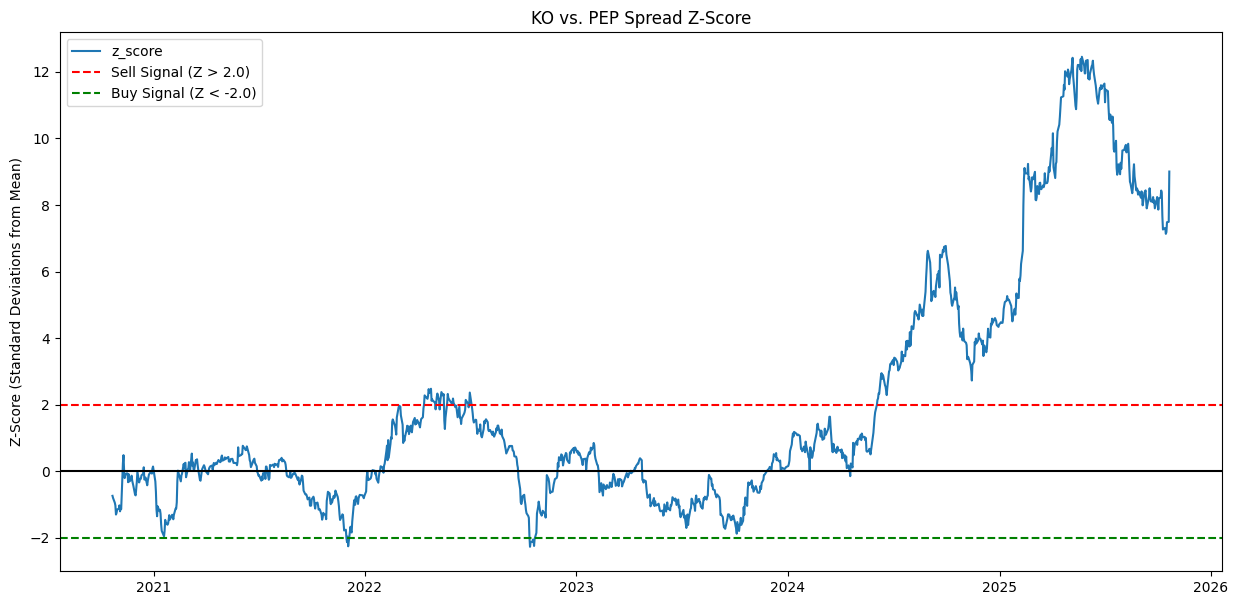

In [73]:
# --- 6. Visualize the Divergence and Signals ---
plt.figure(figsize=(15, 7))
test_df['z_score'].plot()

# Add the signal lines (e.g., at 2.0 and -2.0)
plt.axhline(2.0, color='red', linestyle='--', label='Sell Signal (Z > 2.0)')
plt.axhline(-2.0, color='green', linestyle='--', label='Buy Signal (Z < -2.0)')
plt.axhline(0.0, color='black', linestyle='-')

plt.title(f'{stock_ticker} vs. {market_ticker} Spread Z-Score')
plt.ylabel('Z-Score (Standard Deviations from Mean)')
plt.legend()
plt.show()